In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm

In [2]:
bse = pd.read_csv('./bsedata1.csv', header=[0,1], index_col=0, parse_dates=True, infer_datetime_format=True, dayfirst=True)
nse = pd.read_csv('./nsedata1.csv', header=[0,1], index_col=0, parse_dates=True, infer_datetime_format=True, dayfirst=True)


In [3]:
bselm = bse.last('1M')
nselm = nse.last('1M')

In [4]:
bselm_logr = (bselm/(bselm.shift(1))).dropna().apply(np.log)
nselm_logr = (nselm/(nselm.shift(1))).dropna().apply(np.log)

In [5]:
bselm_vol = bselm_logr.std()*np.sqrt(252)
nselm_vol = nselm_logr.std()*np.sqrt(252)

In [6]:
def bsmopt(S, t, T, K, r, vol, Flag):
    d1 = (np.log(S/K) + (r + (vol/2))*(T-t))/(vol * np.sqrt(T-t));
    d2 = d1 - (vol * np.sqrt(T-t));

#     Flag = 1 for a call option, or Flag = 0 for a put option.
    if (Flag == 1):
        OptionValue = S*norm.cdf(d1, 0, 1) - K*np.exp(-r*(T-t))*norm.cdf(d2, 0, 1);
    else:
        OptionValue = K*np.exp(-r*(T-t))*norm.cdf(-d2, 0, 1) - S*norm.cdf(-d1, 0, 1);
    
    return(OptionValue)

In [7]:
S0_bse = bselm.iloc[-1]
S0_nse = nselm.iloc[-1]

In [8]:
bseoptc = pd.Series({symbol: bsmopt(S0_bse[symbol], 0, 0.5, S0_bse[symbol], 0.05, bselm_vol[symbol], 1) for symbol in S0_bse.index})
bseoptp = pd.Series({symbol: bsmopt(S0_bse[symbol], 0, 0.5, S0_bse[symbol], 0.05, bselm_vol[symbol], 0) for symbol in S0_bse.index})

nseoptc = pd.Series({symbol: bsmopt(S0_nse[symbol], 0, 0.5, S0_nse[symbol], 0.05, nselm_vol[symbol], 1) for symbol in S0_nse.index})
nseoptp = pd.Series({symbol: bsmopt(S0_nse[symbol], 0, 0.5, S0_nse[symbol], 0.05, nselm_vol[symbol], 0) for symbol in S0_nse.index})


In [9]:
bseoptc_k = pd.DataFrame({str(A/10)+'*S0': {symbol: bsmopt(S0_bse[symbol], 0, 0.5, A*S0_bse[symbol]/10, 0.05, bselm_vol[symbol], 1) for symbol in S0_bse.index} for A in range(5, 16)})
bseoptp_k = pd.DataFrame({str(A/10)+'*S0': {symbol: bsmopt(S0_bse[symbol], 0, 0.5, A*S0_bse[symbol]/10, 0.05, bselm_vol[symbol], 0) for symbol in S0_bse.index} for A in range(5, 16)})

nseoptc_k = pd.DataFrame({str(A/10)+'*S0': {symbol: bsmopt(S0_nse[symbol], 0, 0.5, A*S0_nse[symbol]/10, 0.05, nselm_vol[symbol], 1) for symbol in S0_nse.index} for A in range(5, 16)})
nseoptp_k = pd.DataFrame({str(A/10)+'*S0': {symbol: bsmopt(S0_nse[symbol], 0, 0.5, A*S0_nse[symbol]/10, 0.05, nselm_vol[symbol], 0) for symbol in S0_nse.index} for A in range(5, 16)})

###
bseoptc_k.rename_axis(('Position','Symbols'), inplace=True)
bseoptc_k.rename_axis("K", axis="columns", inplace=True)

bseoptp_k.rename_axis(('Position','Symbols'), inplace=True)
bseoptp_k.rename_axis("K", axis="columns", inplace=True)

nseoptc_k.rename_axis(('Position','Symbols'), inplace=True)
nseoptc_k.rename_axis("K", axis="columns", inplace=True)

nseoptp_k.rename_axis(('Position','Symbols'), inplace=True)
nseoptp_k.rename_axis("K", axis="columns", inplace=True)


In [10]:
bseoptc_k.T.to_csv('bseoptc_k.csv')
bseoptp_k.T.to_csv('bseoptp_k.csv')
nseoptc_k.T.to_csv('nseoptc_k.csv')
nseoptp_k.T.to_csv('nseoptp_k.csv')

In [11]:
def slt_vol(S, t): #S is the stock data and t is in months.
    slt = S.last(str(t)+'M')
    slt_logr = (slt/(slt.shift(1))).dropna().apply(np.log)
    slt_vol = slt_logr.std()*np.sqrt(252)
    return slt_vol

In [12]:
bselt_vol = pd.DataFrame({t: slt_vol(bse, t) for t in range(1,61)})
nselt_vol = pd.DataFrame({t: slt_vol(nse, t) for t in range(1,61)})

###
bselt_vol.rename_axis(('Position','Symbols'), inplace=True)
bselt_vol.rename_axis("Historical time period considered in M", axis="columns", inplace=True)

nselt_vol.rename_axis(('Position','Symbols'), inplace=True)
nselt_vol.rename_axis("Historical time period considered in M", axis="columns", inplace=True)


In [13]:
bselt_vol.T.to_csv('bselt_vol.csv')
nselt_vol.T.to_csv('nselt_vol.csv')

In [14]:
bseoptc_t = pd.DataFrame({t: {symbol: bsmopt(S0_bse[symbol], 0, 0.5, S0_bse[symbol], 0.05, bselt_vol[t][symbol], 1) for symbol in S0_bse.index} for t in range(1, 61)})
bseoptp_t = pd.DataFrame({t: {symbol: bsmopt(S0_bse[symbol], 0, 0.5, S0_bse[symbol], 0.05, bselt_vol[t][symbol], 0) for symbol in S0_bse.index} for t in range(1, 61)})

nseoptc_t = pd.DataFrame({t: {symbol: bsmopt(S0_nse[symbol], 0, 0.5, S0_nse[symbol], 0.05, nselt_vol[t][symbol], 1) for symbol in S0_nse.index} for t in range(1, 61)})
nseoptp_t = pd.DataFrame({t: {symbol: bsmopt(S0_nse[symbol], 0, 0.5, S0_nse[symbol], 0.05, nselt_vol[t][symbol], 0) for symbol in S0_nse.index} for t in range(1, 61)})

###
bseoptc_t.rename_axis(('Position','Symbols'), inplace=True)
bseoptc_t.rename_axis("Historical time period considered in M", axis="columns", inplace=True)

bseoptp_t.rename_axis(('Position','Symbols'), inplace=True)
bseoptp_t.rename_axis("Historical time period considered in M", axis="columns", inplace=True)

nseoptc_t.rename_axis(('Position','Symbols'), inplace=True)
nseoptc_t.rename_axis("Historical time period considered in M", axis="columns", inplace=True)

nseoptp_t.rename_axis(('Position','Symbols'), inplace=True)
nseoptp_t.rename_axis("Historical time period considered in M", axis="columns", inplace=True)


In [15]:
bseoptc_t.T.to_csv('bseoptc_t.csv')
bseoptp_t.T.to_csv('bseoptp_t.csv')
nseoptc_t.T.to_csv('nseoptc_t.csv')
nseoptp_t.T.to_csv('nseoptp_t.csv')

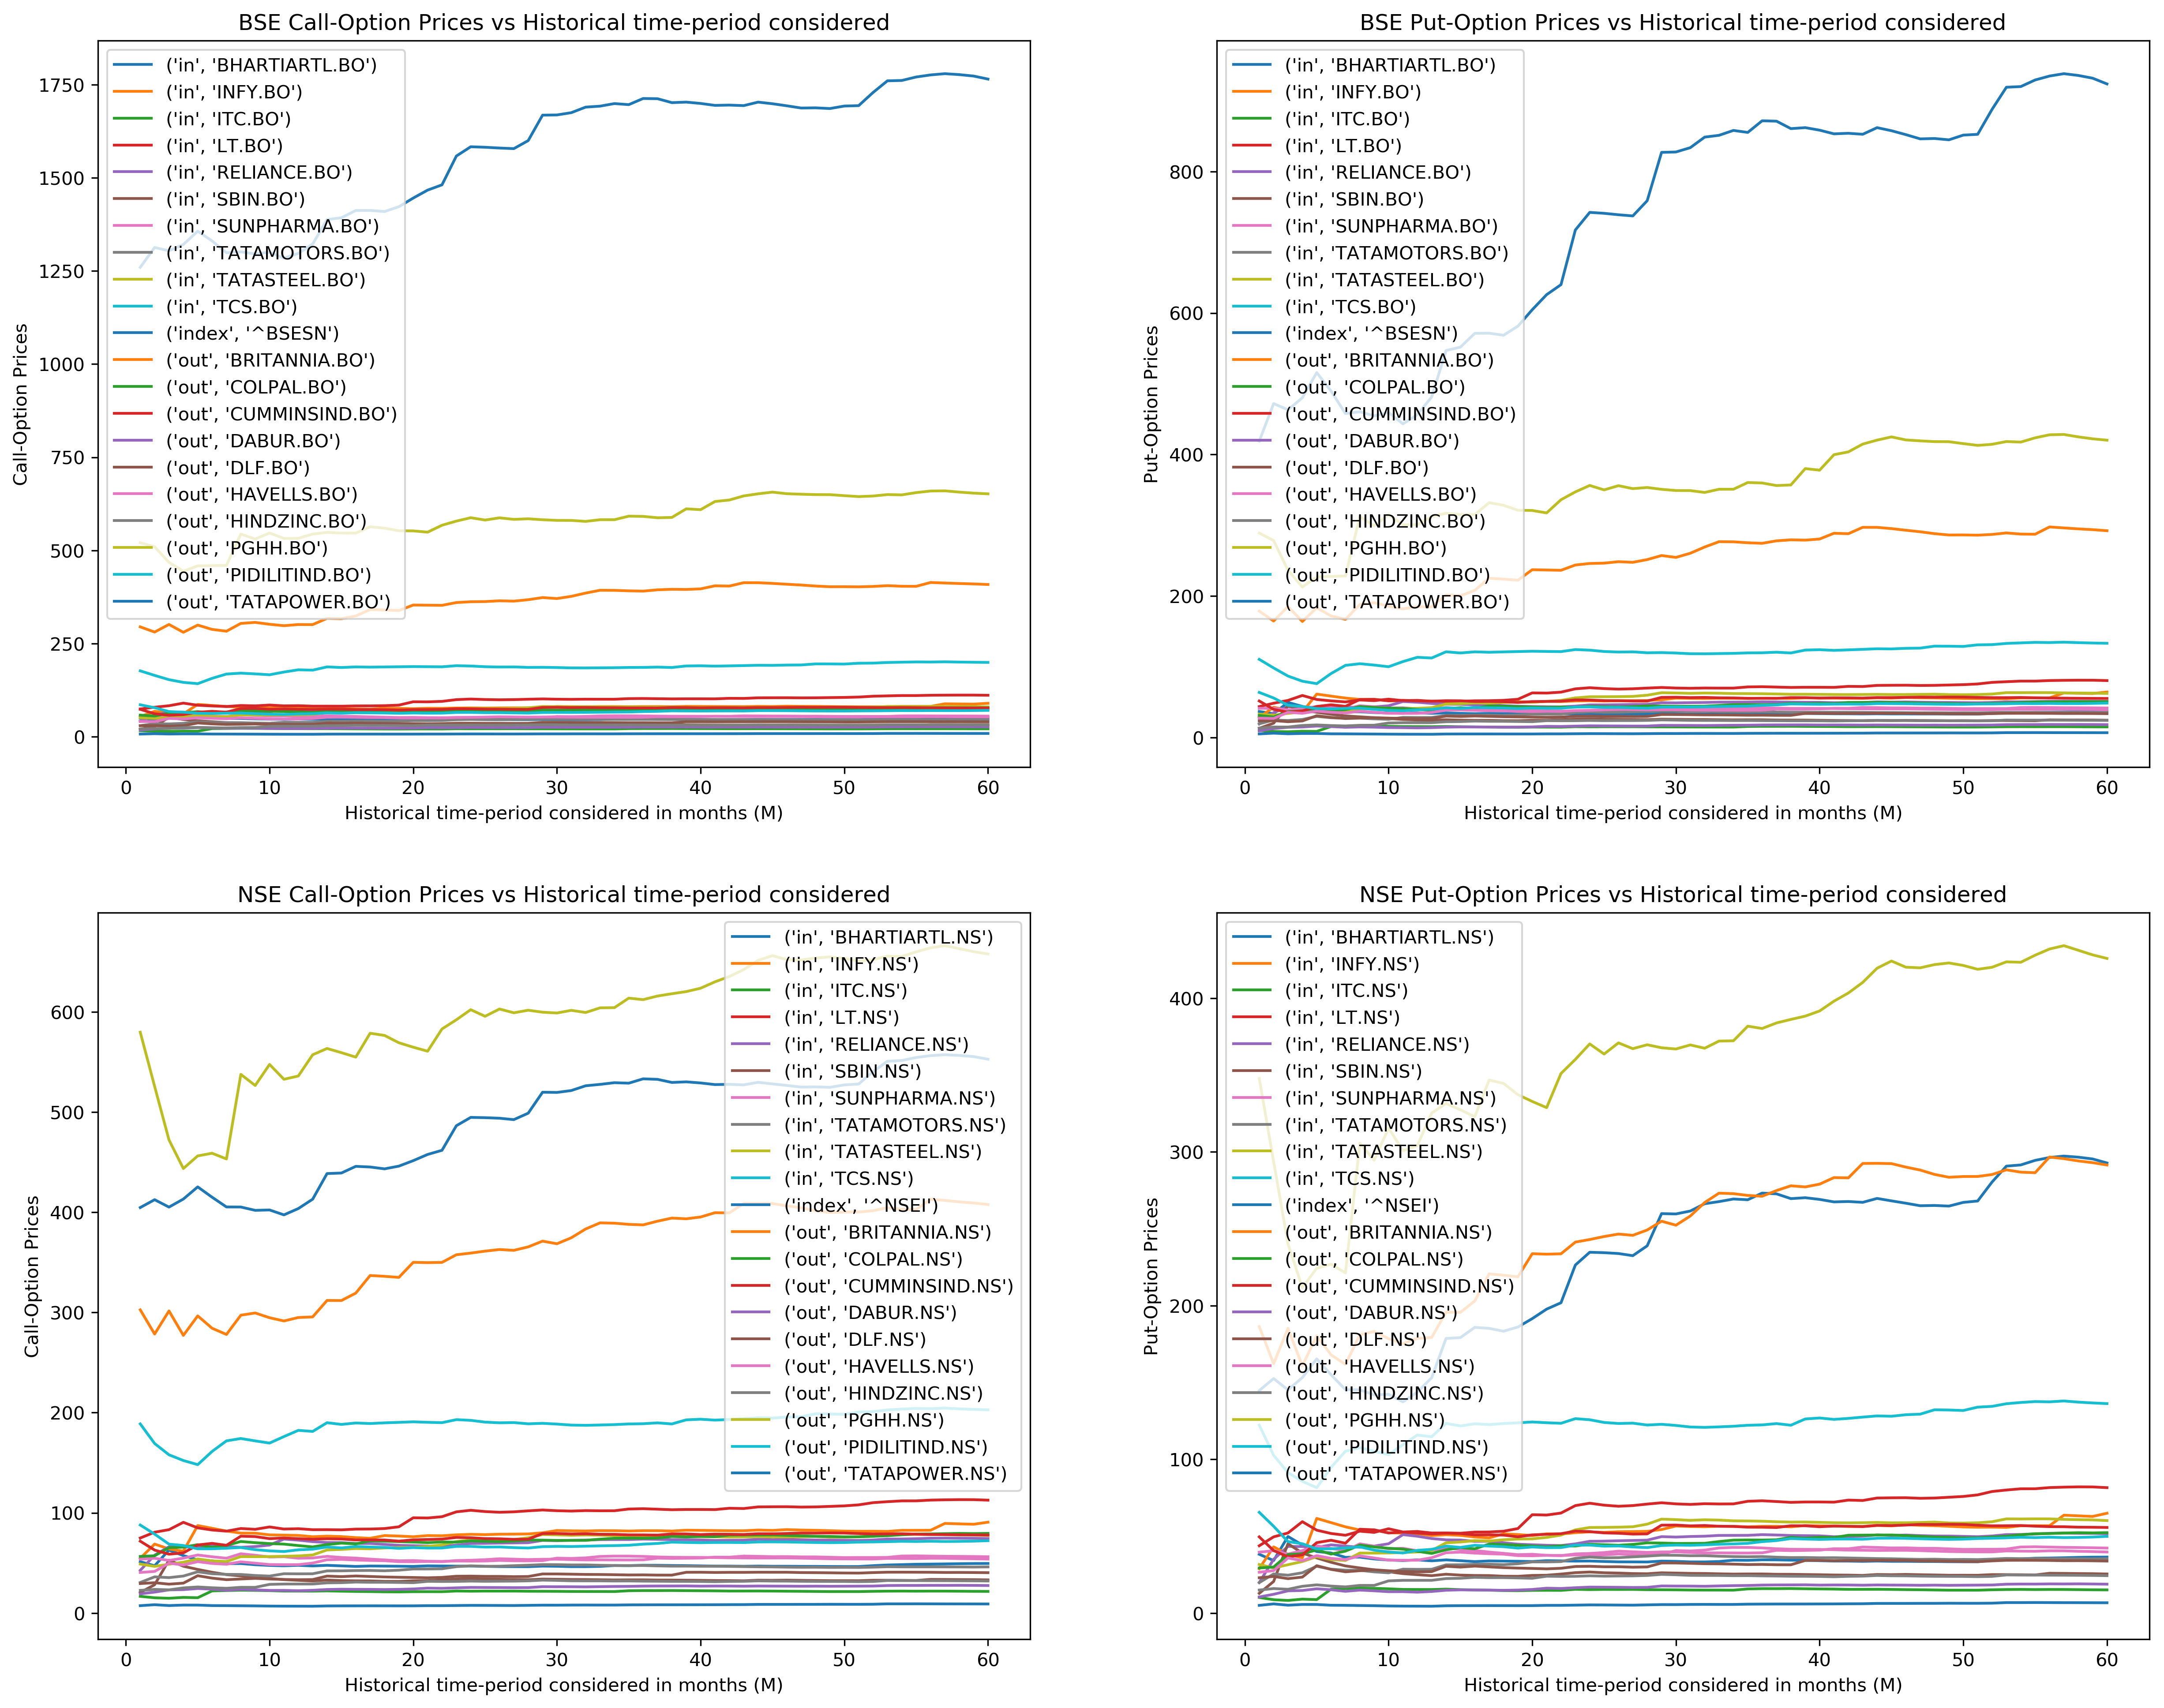

In [16]:
plt.figure(num=None, figsize=(20, 16), dpi=300, facecolor='w', edgecolor='k')

plt.subplot(2, 2, 1)
plt.plot(bseoptc_t.T)
plt.title('BSE Call-Option Prices vs Historical time-period considered')
plt.legend(bseoptc_t.index)
plt.ylabel('Call-Option Prices')
plt.xlabel('Historical time-period considered in months (M)')

plt.subplot(2, 2, 2)
plt.plot(bseoptp_t.T)
plt.title('BSE Put-Option Prices vs Historical time-period considered')
plt.legend(bseoptp_t.index)
plt.ylabel('Put-Option Prices')
plt.xlabel('Historical time-period considered in months (M)')

plt.subplot(2, 2, 3)
plt.plot(nseoptc_t.T)
plt.title('NSE Call-Option Prices vs Historical time-period considered')
plt.legend(nseoptc_t.index)
plt.ylabel('Call-Option Prices')
plt.xlabel('Historical time-period considered in months (M)')

plt.subplot(2, 2, 4)
plt.plot(nseoptp_t.T)
plt.title('NSE Put-Option Prices vs Historical time-period considered')
plt.legend(nseoptp_t.index)
plt.ylabel('Put-Option Prices')
plt.xlabel('Historical time-period considered in months (M)')

plt.savefig('Opt_T.jpg', dpi=300, bbox_inches='tight')

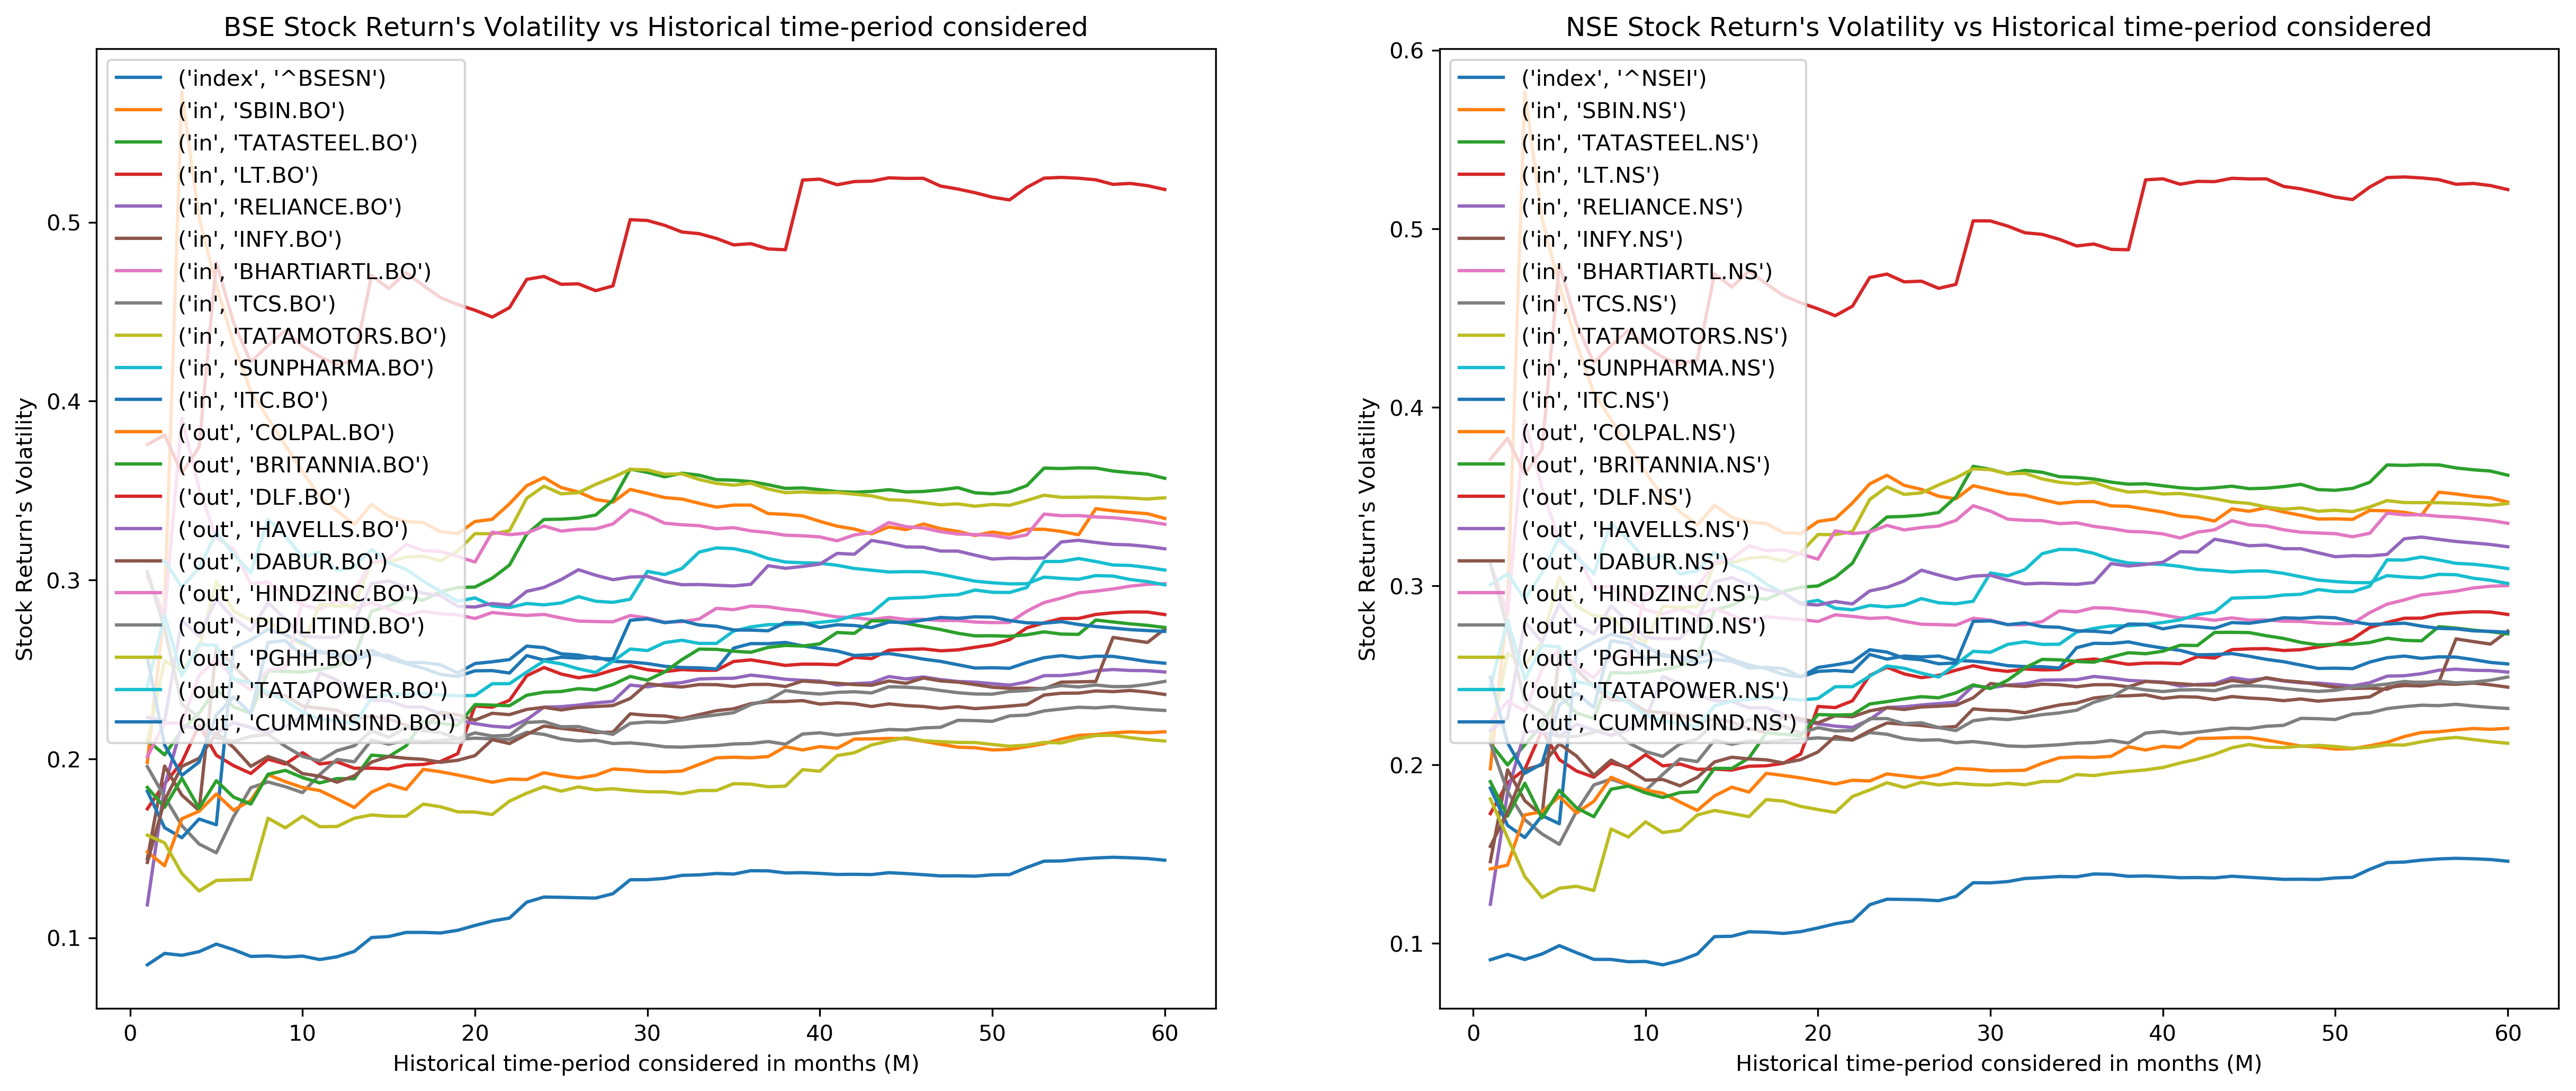

In [17]:
plt.figure(num=None, figsize=(20, 8), dpi=300, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.plot(bselt_vol.T)
plt.title("BSE Stock Return's Volatility vs Historical time-period considered")
plt.legend(bselt_vol.index)
plt.ylabel("Stock Return's Volatility")
plt.xlabel('Historical time-period considered in months (M)')

plt.subplot(1, 2, 2)
plt.plot(nselt_vol.T)
plt.title("NSE Stock Return's Volatility vs Historical time-period considered")
plt.legend(nselt_vol.index)
plt.ylabel("Stock Return's Volatility")
plt.xlabel('Historical time-period considered in months (M)')

plt.savefig('Vol_T.jpg', dpi=300, bbox_inches='tight')